In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

import torch
from torch import nn
import torch.nn.functional as functional
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
torch.manual_seed(862)

---

# Загрузка данных

In [4]:
train_fh = open('datasets/lego-train.pickle', 'rb')
test_fh = open('datasets/lego-test.pickle', 'rb')

train_data = pickle.load(train_fh)
test_data = pickle.load(test_fh)

In [5]:
x_train, y_train = zip(*train_data)
x_test, y_test = zip(*test_data)

x_train = np.array(x_train).astype(np.float32)
y_train = np.array(y_train)
x_test  = np.array(x_test).astype(np.float32)
y_test  = np.array(y_test)

In [6]:
x_train = np.array([img.flatten() for img in x_train])
x_test  = np.array([img.flatten() for img in x_test])

In [7]:
x_train = x_train / 255.0
x_test  = x_test / 255.0

In [8]:
x_train

array([[0.03529412, 0.03529412, 0.03529412, ..., 0.05490196, 0.05490196,
        0.05490196],
       [0.01960784, 0.01960784, 0.01960784, ..., 0.05490196, 0.05490196,
        0.05490196],
       [0.00784314, 0.00784314, 0.00784314, ..., 0.02352941, 0.02352941,
        0.02352941],
       ...,
       [0.00784314, 0.00784314, 0.00784314, ..., 0.01960784, 0.01960784,
        0.01960784],
       [0.00784314, 0.00784314, 0.00784314, ..., 0.01960784, 0.01960784,
        0.01960784],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [9]:
class_names = ['2x3 Brick', '2x2 Brick', '1x3 Brick', '2x1 Brick', '1x1 Brick', '2x2 Macaroni', '2x2 Curved End', 'Cog 16 Tooth', '1x2 Handles', '1x2 Grill']

In [10]:
image_width = 48
image_height = 48

In [11]:
def plot_img(data, label):
    plt.figure()
    plt.imshow(data.reshape((image_width, image_height)))
    plt.colorbar()
    plt.xlabel(class_names[label])
    plt.show()

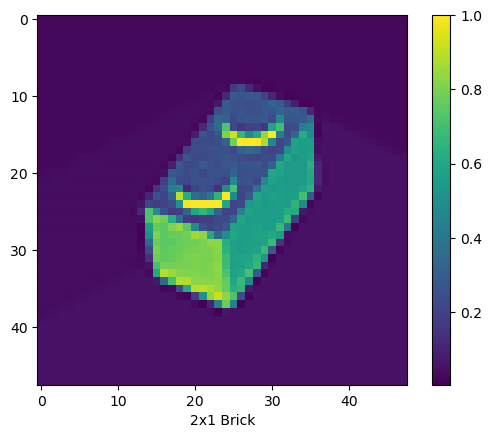

In [12]:
img_number = 126
plot_img(x_train[img_number], y_train[img_number])

## Преобразование данных в pytorch tensors из numpy ndarray

In [13]:
x_train = torch.tensor(x_train).to(device)
y_train = torch.tensor(y_train).to(device)
x_test  = torch.tensor(x_test).to(device)
y_test  = torch.tensor(y_test).to(device)

In [14]:
x_train, x_test

(tensor([[0.0353, 0.0353, 0.0353,  ..., 0.0549, 0.0549, 0.0549],
         [0.0196, 0.0196, 0.0196,  ..., 0.0549, 0.0549, 0.0549],
         [0.0078, 0.0078, 0.0078,  ..., 0.0235, 0.0235, 0.0235],
         ...,
         [0.0078, 0.0078, 0.0078,  ..., 0.0196, 0.0196, 0.0196],
         [0.0078, 0.0078, 0.0078,  ..., 0.0196, 0.0196, 0.0196],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
        device='cuda:0'),
 tensor([[0.0353, 0.0353, 0.0353,  ..., 0.0549, 0.0549, 0.0549],
         [0.0196, 0.0196, 0.0196,  ..., 0.0549, 0.0549, 0.0549],
         [0.0078, 0.0078, 0.0078,  ..., 0.0235, 0.0235, 0.0235],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0196, 0.0196, 0.0196],
         [0.0196, 0.0196, 0.0196,  ..., 0.0353, 0.0353, 0.0353],
         [0.0078, 0.0078, 0.0078,  ..., 0.0235, 0.0235, 0.0235]],
        device='cuda:0'))

---

# Создание модели

In [15]:
learning_rate = 0.1
epochs = 30
batch_size = 34

In [16]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_ds  = TensorDataset(x_test, y_test)
test_dl  = DataLoader(test_ds, batch_size=batch_size * 2)

In [17]:
class TorchModule(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

def preprocess(x):
    return x.view(-1, 1, image_width, image_height).to(device)

model = nn.Sequential(
    TorchModule(preprocess),
    nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=2),
    nn.ReLU(),
    nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=2),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=2),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=2),
    nn.ReLU(),
    nn.AvgPool2d(4),
    TorchModule(lambda x: x.view(x.size(0), -1)),
)

if torch.cuda.is_available():
    model = model.to(device)

In [18]:
# функция активации и функция потерь
opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
loss_func = functional.cross_entropy

In [19]:
# Вспомогательная функция для вычисления точности
def accuracy(out, labels):
    preds = torch.argmax(out, dim=1)
    return (preds == labels).float().mean()

# loss_batch вычисляет потери и предназначен для использования во время обучения.
# Если оптимизатор не передается, значит, мы находимся на этапе тестирования модели и пропускаем его.
def loss_batch(model, loss_func, xb, yb, opt=None):
    out = model(xb)
    loss = loss_func(out, yb)
    acc = accuracy(out, yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), acc.item(), len(xb)

# Мы пишем нашу собственную функцию fit.
# По мере прохождения эпох мы сохраняем значение потерь и точности.
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    history_loss = []
    history_acc = []
    
    for epoch in range(epochs):
        # Обучение
        model.train()
        for xb, yb in train_dl:
            loss, _, _ = loss_batch(model, loss_func, xb, yb, opt)

        # Валидация
        model.eval()
        with torch.no_grad():
            losses, accs, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_acc  = np.sum(np.multiply(accs, nums))   / np.sum(nums)
        
        history_loss.append(val_loss)
        history_acc.append(val_acc)
        
        print(f'Epoch {epoch + 1}/{epochs}: Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}')
        
    print('[Done]')
    return history_loss, history_acc


# Обучение модели

In [20]:
loss, accuracy = fit(epochs, model, loss_func, opt, train_dl, test_dl)

Epoch 1/30: Loss: 2.3009, Accuracy: 0.1133
Epoch 2/30: Loss: 2.3026, Accuracy: 0.1133
Epoch 3/30: Loss: 2.3056, Accuracy: 0.0933
Epoch 4/30: Loss: 2.3018, Accuracy: 0.0933
Epoch 5/30: Loss: 2.2973, Accuracy: 0.1467
Epoch 6/30: Loss: 2.2833, Accuracy: 0.1133
Epoch 7/30: Loss: 2.2730, Accuracy: 0.1133
Epoch 8/30: Loss: 2.2236, Accuracy: 0.2400
Epoch 9/30: Loss: 2.0903, Accuracy: 0.2133
Epoch 10/30: Loss: 1.9547, Accuracy: 0.3800
Epoch 11/30: Loss: 1.8358, Accuracy: 0.3400
Epoch 12/30: Loss: 1.6864, Accuracy: 0.4800
Epoch 13/30: Loss: 1.5846, Accuracy: 0.4200
Epoch 14/30: Loss: 1.4775, Accuracy: 0.5133
Epoch 15/30: Loss: 1.2558, Accuracy: 0.6200
Epoch 16/30: Loss: 1.1669, Accuracy: 0.6000
Epoch 17/30: Loss: 1.0247, Accuracy: 0.6467
Epoch 18/30: Loss: 0.5983, Accuracy: 0.8133
Epoch 19/30: Loss: 0.2589, Accuracy: 0.8933
Epoch 20/30: Loss: 0.4590, Accuracy: 0.8333
Epoch 21/30: Loss: 0.5441, Accuracy: 0.8000
Epoch 22/30: Loss: 1.0013, Accuracy: 0.7933
Epoch 23/30: Loss: 0.7831, Accuracy: 0.75

In [21]:
def plot_history(history, y_axis_label = ''):
    plt.figure(figsize=(7, 4))
    plt.plot(history)
    plt.title('Model ' + y_axis_label)
    plt.ylabel(y_axis_label)
    plt.xlabel('Epoch')
    return

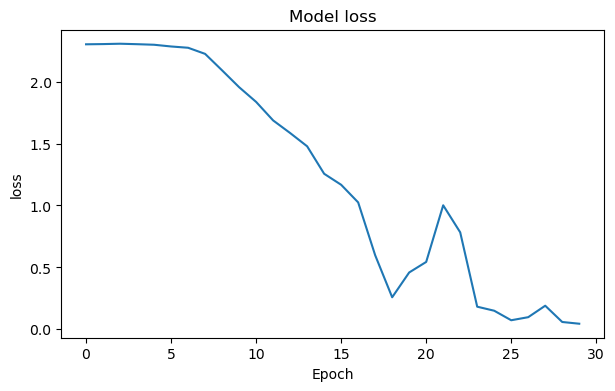

In [22]:
plot_history(loss, 'loss')

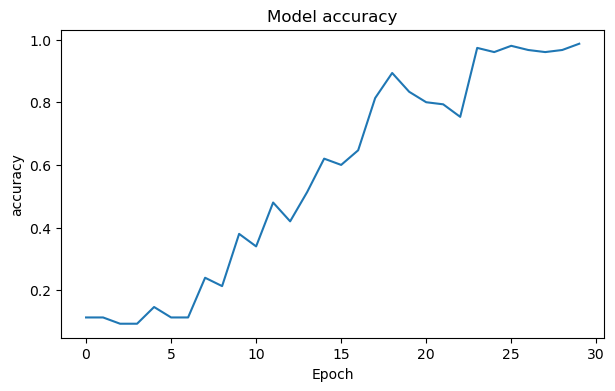

In [23]:
plot_history(accuracy, 'accuracy')

# Тестирование модели

In [24]:
img_to_test = 0

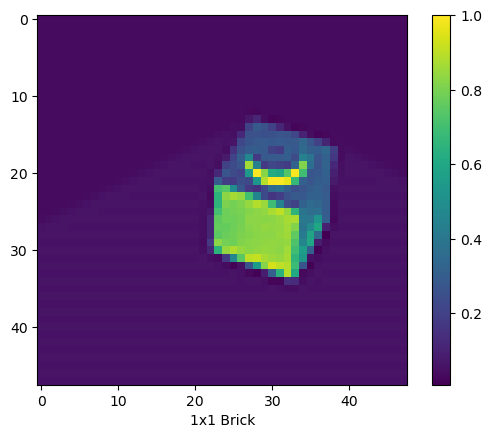

In [25]:
plot_img(x_test[img_to_test].cpu().numpy(), y_test[img_to_test].cpu().numpy())

In [26]:
p = model(x_test[img_to_test])

prediction = torch.argmax(p)
class_label = class_names[prediction.cpu().numpy()]

prediction, class_label

(tensor(4, device='cuda:0'), '1x1 Brick')

In [27]:
def plot_image(predictions_array, true_label, img):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.reshape((image_width, image_height)), cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    # Print a label with 'predicted class', 'probability %', 'actual class'
    plt.xlabel("{} [{:2.0f}] ({})".format(class_names[predicted_label],
                                  np.max(predictions_array),
                                  class_names[true_label]),
                                  color=color)

# Function to display the prediction results in a graph:
def plot_value_array(predictions_array, true_label):
  plt.xticks(range(10))
  plt.yticks([])
  plot = plt.bar(range(10), predictions_array, color="#777777")
  predicted_label = np.argmax(predictions_array)
  plot[predicted_label].set_color('red')
  plot[true_label].set_color('green')

In [28]:
predictions = model(x_test)

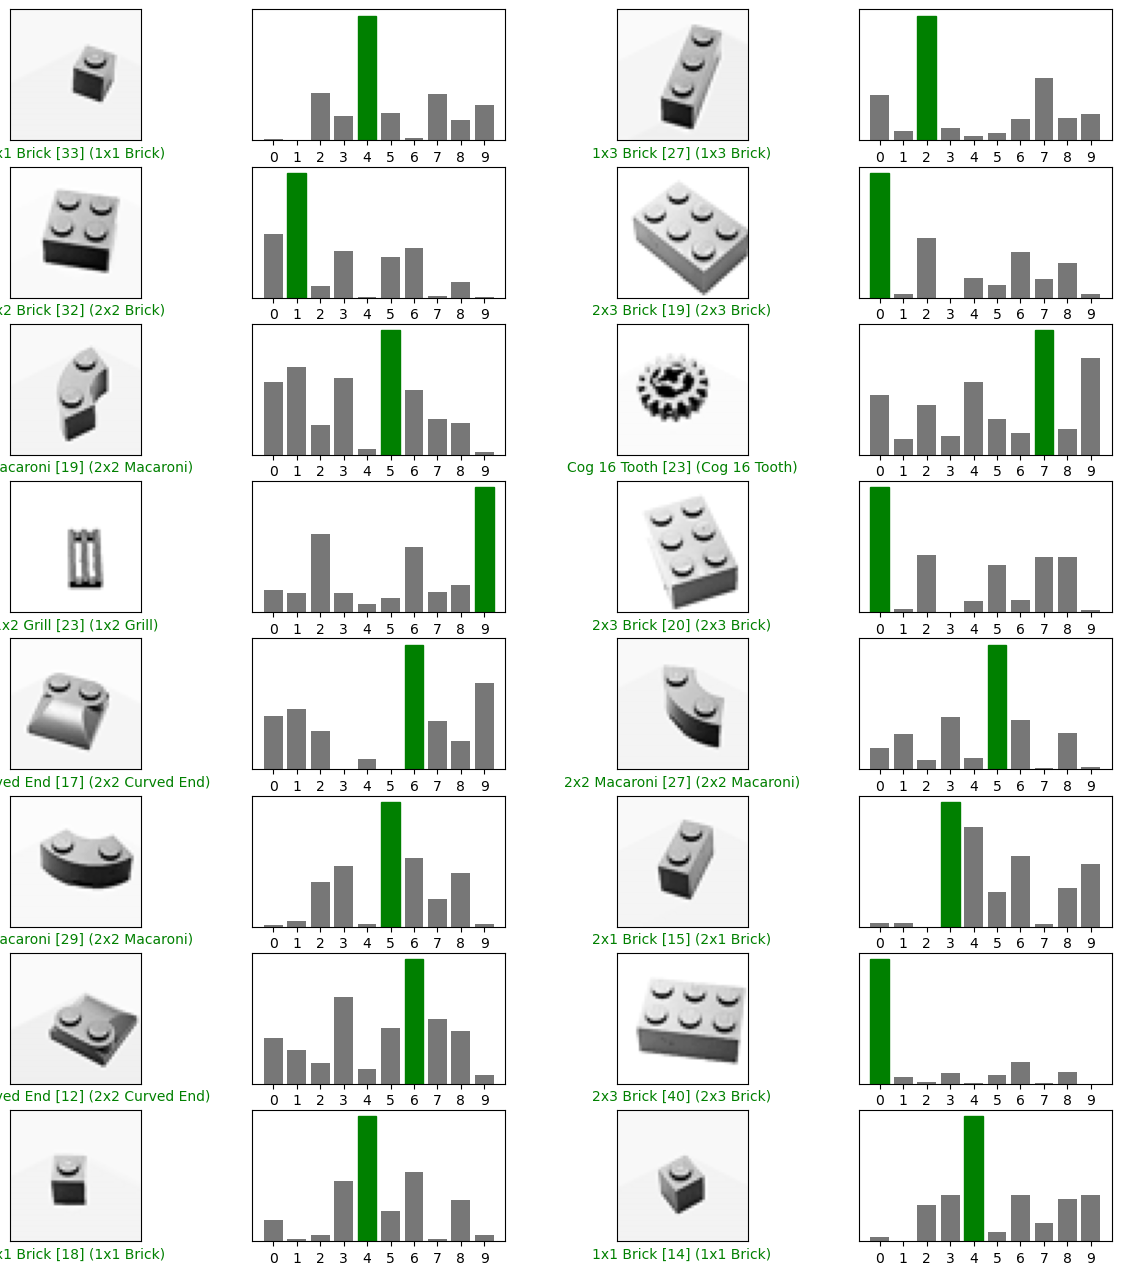

In [29]:
num_rows = 8
num_cols = 2

num_images = num_rows*num_cols
plt.figure(figsize=(15, 16))

for i in range(num_images):
    ipred = predictions[i].detach().cpu().numpy()
    iimg = x_train[i].detach().cpu().numpy()
    ilab = y_test[i].detach().cpu().numpy()
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(ipred, ilab, iimg)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(ipred, ilab)
plt.show()